In [1]:
import pandas as pd
import random
from utilities.utils import *
from utilities.sentence_classifier import LSTMDataset
from utilities.tokenizer_class import TokenizerClass
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch
from datasets import Dataset
from transformers import DataCollatorWithPadding
from evaluate import load
import numpy as np
trans_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-german-cased')
import os
os.environ['TOKENIZERS_PARALLELISM']='1'
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jannis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Function definition*

In [2]:
wandb.init(
    project='pretrain-transform-wiki',
    config={
    'class_size':2000,
    'random_state':2,
    'eval_metric':'accuracy',
    'eval_share':0.25,
    'batch_size':256, #256
    'epochs':4,
    'huggingface_model':'distilbert-base-german-cased',
    'loss_function':None,
    'learning_rate':0.00032,
    }
)
config=wandb.config

wandb: Currently logged in as: ether-meter. Use `wandb login --relogin` to force relogin


In [3]:
def preprocess_transformer_token(example):
    return trans_tokenizer(example['text'], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=trans_tokenizer)

accuracy = load(config.eval_metric)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



*Create trainining & eval dataset*

In [4]:
class_size = config.class_size

# lstm_dataset=LSTMDataset()
# lstm_dataset.load_datasets('data/data_files/test_samples/2nd_test_dataset_samples/nopos_resolved_namelink_nofilter_equal.csv')
df = pd.read_csv(
    '../data/data_files/test_samples/2nd_test_dataset_samples/nopos_resolved_namelink_nofilter_equal.csv',nrows=2500
)
test_share = 0.25
eff_val_share = config.eval_share / (1 - test_share)



wiki_dataset = Dataset.from_pandas(df,preserve_index=False)
tokenized_wiki = wiki_dataset.map(preprocess_transformer_token,batched=True)
test_split = tokenized_wiki.train_test_split(config.eval_share)
test_set = test_split['test']
val_split = test_split['train'].train_test_split(config.eval_share)


  0%|          | 0/3 [00:00<?, ?ba/s]

In [14]:
print(tokenized_wiki['input_ids'])

[[102, 229, 3690, 12925, 338, 3645, 16962, 818, 5459, 125, 6570, 190, 9031, 308, 818, 377, 128, 12903, 686, 7623, 30881, 260, 125, 5288, 9073, 447, 255, 205, 1140, 341, 103], [102, 351, 2521, 371, 18292, 818, 377, 143, 10012, 30886, 6985, 10721, 125, 3906, 2764, 125, 9298, 962, 125, 4516, 668, 24636, 131, 1878, 8161, 3269, 30885, 208, 403, 4596, 343, 25998, 13054, 103], [102, 8644, 7686, 30886, 29712, 30884, 21240, 5535, 14099, 11234, 809, 10644, 10109, 439, 246, 232, 3822, 1886, 809, 336, 16387, 30881, 1021, 4684, 205, 3541, 103], [102, 2399, 3837, 284, 132, 222, 3729, 15364, 30886, 1128, 3462, 128, 25202, 106, 27116, 338, 2816, 107, 1193, 5109, 360, 23506, 30881, 103], [102, 21616, 325, 153, 190, 8584, 136, 8735, 30783, 9810, 2449, 818, 2588, 2303, 7056, 276, 223, 4163, 9706, 818, 476, 128, 15139, 7896, 27619, 262, 6280, 335, 1586, 4871, 608, 103], [102, 2413, 3923, 9238, 263, 10165, 153, 893, 1373, 341, 28694, 1695, 3323, 11810, 103], [102, 8564, 1334, 14478, 6379, 22095, 30887, 333

In [12]:
print((val_split['train']['text']))

['Die längsten Tauchgänge erreichen Tauchgänge Zeiten von über 20 Minuten , normalerweise sind Tauchgänge jedoch mit durchschnittlich drei bis zehn Minuten deutlich kürzer ', 'Begründet 1949 von Helmut de Boor und Richard Newald ', 'Einige Menschen haben die Fähigkeit , durch gezieltes Spannen des Darmschließmuskels die Tonhöhe der Abwinde zu modulieren ', 'Der LPPM stellt wie der London Bullion Market die Ausnahme unter den Rohstoffmärkten dar : LPPM ist keine Börse , sondern ein OTC-Markt ', 'Bergoglio spricht fließend Italienisch und soll den italienischen Dialekt der Gegend um Portacomaro und die Lieder der Auswanderer beherrschen ', 'Dagegen sind Öl- und Feigenbäume häufig angepflanzt zu finden ', 'entstand dort eine mehrphasige Befestigungslage ', 'Pizarro fand ein Reich vor , das in einen Bruderkrieg zwischen den Brüdern Atahualpa und Huáscar verstrickt war ', 'Am   Juli 1940 gelang Tadeusz Wiejowski die erste Flucht in Begleitung von zwei Mitgliedern der polnischen Widerstandsb

# Tensorflow

In [6]:
from transformers import create_optimizer
import tensorflow as tf
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from transformers import TFAutoModelForSequenceClassification

batch_size = config.batch_size
num_epochs = config.epochs
batches_per_epoch = len(val_split['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=config.learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps)


model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-german-cased", num_labels=2,from_pt=True)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-28 14:40:52.312064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 14:40:52.312410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification mode

In [7]:
tf_train_set = model.prepare_tf_dataset(
    val_split['train'],
    shuffle=True,
    batch_size=config.batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    val_split["test"],
    shuffle=False,
    batch_size=config.batch_size,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer,)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [8]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)
push_to_hub_callback = PushToHubCallback(
    output_dir="new_version123",
    tokenizer=trans_tokenizer,
)

# callbacks = [metric_callback, push_to_hub_callback,WandbMetricsLogger(log_freq=5),WandbModelCheckpoint('models')]
callbacks = [
    metric_callback, push_to_hub_callback,
]


/Users/jannis/Desktop/GitRepos/Master/masterthesis/Master_Thesis/Transformer/new_version123 is already a clone of https://huggingface.co/whathefish/new_version123. Make sure you pull the latest changes with `repo.git_pull()`.


## Train 

In [9]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=config.epochs)

Epoch 1/4


2023-03-28 14:41:05.501217: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-28 14:41:09.930138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 0.5967 

2023-03-28 14:43:58.689955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 178s 36s/step - loss: 0.5967 - val_loss: 0.5696
Epoch 2/4
1/5 [=====>........................] - ETA: 1:43 - loss: 0.5808

In [12]:
print(tf.test.is_gpu_available) 

<function is_gpu_available at 0x29738d670>


## Evaluate w/ test-data

In [ ]:
annotated=pd.read_csv('FullAnnotated1.csv',sep=';',dtype={'sentence':'str'})
annotated=annotated[annotated['to_exclude']==0]
df_test=pd.DataFrame()
df_test['text']=annotated['sentence']
df_test['label']=annotated['is_claim']
dataset_test=Dataset.from_pandas(df_test,preserve_index=False)
sentence_list = list(df_test['text'])
tokenized = trans_tokenizer(sentence_list,return_tensors='np',padding='longest')
outputs = model(tokenized).logits

In [21]:
df = pd.read_csv(
    '../data/data_files/test_samples/2nd_test_dataset_samples/nopos_resolved_namelink_nofilter_equal.csv',
    )

In [26]:
for i in range(15):
    print(text[i])

Die einzelnen Szenen werden meist abgebrochen , obwohl der Zuschauer den Eindruck hat , dass die Handlung sowie Dialoge aus der jeweiligen Szene noch nicht zu Ende sind 
Der Gruppe wird vorgeworfen , dass ein spezielles Rettungsfahrzeug der Feuerwehr aufgrund der Blockade der Berliner Stadtautobahn A 100 verspätet an einem Unfallort eintraf 
Black Lives Matter nutzten ursprünglich Social Media – inklusive Hashtag-Aktivismus – um tausende Menschen gleichzeitig zu erreichen 
Zur Erzielung des gleichen Effekts müssen deshalb die Dosen gesteigert werden Tachyphylaxie 
Grundsätzlich wurde in den westlichen und südlichen Operationsgebieten Frankreich , Italien weniger zerstört als im Osten Sowjetunion , wo die Zerstörungsmaßnahmen so komplett wie möglich durchgeführt wurden 
Alle oberirdischen Halte in diesem Bereich sind stadtbahnmäßig ausgebaut 
Zwar konnte Muawiya nach Alis Ermordung durch die Charidschiten im Jahr 661 Muawiya Herrschaft durchsetzen , doch wurde Großreichs von den Anhänge

In [23]:
text = df['text']
print(min(text[1000:2500],key=len))

shortest_index = min(enumerate(text[1000:2500]), key=lambda x: len(x[1]))[0]
print(shortest_index)

m
1140


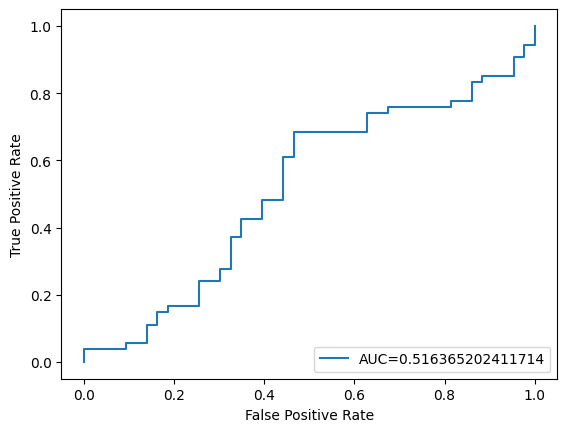

In [ ]:
softmaxed = tf.nn.softmax(outputs)
softmaxed = softmaxed.numpy()
probabilities =[]
for i in softmaxed:
    probabilities.append((i)[1])
a,b=plot_compute_AUC(annotated['is_claim'],  probabilities)

In [ ]:
print(b)

0.516365202411714


In [ ]:
classifications = np.argmax(outputs,axis=1)
ground_truth = list(classifications)
predictions = list(df_test['label'])
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions)
recall = recall_score(ground_truth, predictions)
f1score=f1_score(ground_truth, predictions)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
wandb.log({'AUC':b,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1-Score':f1score})

Accuracy: 0.52, Precision: 0.91, Recall: 0.54


In [ ]:
wandb.finish()
raise KeyboardInterrupt("Until autorun till here!")


batch/batch_step,▁█
batch/learning_rate,█▁
batch/loss,▁█
batch/batch_step,5
batch/learning_rate,0.00027
batch/loss,0.70237


KeyboardInterrupt: Until autorun till here!

# Pytorch

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-german-cased", num_labels=2
)

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_tokenized['train'],
    eval_dataset=split_tokenized['test'],
    tokenizer=trans_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


